# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para estimar **qué tan alquilable es un listing**. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Análisis de valores faltantes y patrones de disponibilidad
- Visualizaciones que permitan interpretar la ocupación y sus drivers
- Definición de un problema supervisado de clasificación enfocado en la alta ocupación
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y selección/reducción de dimensionalidad


# 🏡 Airbnb Listings Data Dictionary

> Diccionario de datos del conjunto de listados de Airbnb, con tipos de datos, campos calculados y descripciones.  
> Compatible con visualización en GitHub (scroll horizontal automático en tablas grandes).

---

<div style="overflow-x: auto;">

| **Field** | **Type** | **Calculated** | **Description** |
|------------|-----------|----------------|-----------------|
| id | integer |  | Airbnb's unique identifier for the listing |
| listing_url | text | ✅ |  |
| scrape_id | bigint | ✅ | Inside Airbnb "Scrape" this was part of |
| last_scraped | datetime | ✅ | UTC. The date and time this listing was "scraped". |
| source | text |  | One of `"neighbourhood search"` or `"previous scrape"`. Describes how the listing was discovered. |
| name | text |  | Name of the listing |
| description | text |  | Detailed description of the listing |
| neighborhood_overview | text |  | Host's description of the neighbourhood |
| picture_url | text |  | URL to Airbnb-hosted regular-sized image |
| host_id | integer |  | Airbnb's unique identifier for the host/user |
| host_url | text | ✅ | Airbnb page for the host |
| host_name | text |  | Name of the host (usually first name). |
| host_since | date |  | Host account creation date |
| host_location | text |  | Host's self-reported location |
| host_about | text |  | Description about the host |
| host_response_time | text |  |  |
| host_response_rate | text |  |  |
| host_acceptance_rate | text |  | Rate at which host accepts booking requests |
| host_is_superhost | boolean *(t=true; f=false)* |  |  |
| host_thumbnail_url | text |  |  |
| host_picture_url | text |  |  |
| host_neighbourhood | text |  |  |
| host_listings_count | text |  | Number of listings (Airbnb internal) |
| host_total_listings_count | text |  | Total listings (Airbnb internal) |
| host_verifications | text |  |  |
| host_has_profile_pic | boolean *(t=true; f=false)* |  |  |
| host_identity_verified | boolean *(t=true; f=false)* |  |  |
| neighbourhood | text |  |  |
| neighbourhood_cleansed | text | ✅ | Geocoded neighbourhood (from shapefiles) |
| neighbourhood_group_cleansed | text | ✅ | Geocoded neighbourhood group (from shapefiles) |
| latitude | numeric |  | WGS84 latitude |
| longitude | numeric |  | WGS84 longitude |
| property_type | text |  | Self-selected property type |
| room_type | text |  | One of:<br>• **Entire home/apt** — Whole space<br>• **Private room** — Own room, shared areas<br>• **Shared room** — Shared sleeping space |
| accommodates | integer |  | Max guest capacity |
| bathrooms | numeric |  | Number of bathrooms |
| bathrooms_text | string |  | Text description of bathrooms (legacy field) |
| bedrooms | integer |  | Number of bedrooms |
| beds | integer |  | Number of beds |
| amenities | json |  | JSON array of amenities |
| price | currency |  | Daily price (ignore `$` artifact) |
| minimum_nights | integer |  | Minimum nights allowed |
| maximum_nights | integer |  | Maximum nights allowed |
| minimum_minimum_nights | integer | ✅ | Smallest min nights (calendar, 365 days ahead) |
| maximum_minimum_nights | integer | ✅ | Largest min nights (calendar, 365 days ahead) |
| minimum_maximum_nights | integer | ✅ | Smallest max nights (calendar, 365 days ahead) |
| maximum_maximum_nights | integer | ✅ | Largest max nights (calendar, 365 days ahead) |
| minimum_nights_avg_ntm | numeric | ✅ | Avg min nights (calendar, 365 days ahead) |
| maximum_nights_avg_ntm | numeric | ✅ | Avg max nights (calendar, 365 days ahead) |
| calendar_updated | date |  |  |
| has_availability | boolean |  | *(t=true; f=false)* |
| availability_30 | integer | ✅ | Available nights (next 30 days) |
| availability_60 | integer | ✅ | Available nights (next 60 days) |
| availability_90 | integer | ✅ | Available nights (next 90 days) |
| availability_365 | integer | ✅ | Available nights (next 365 days) |
| calendar_last_scraped | date |  |  |
| number_of_reviews | integer |  | Total number of reviews |
| number_of_reviews_ltm | integer | ✅ | Reviews in last 12 months |
| number_of_reviews_l30d | integer | ✅ | Reviews in last 30 days |
| first_review | date | ✅ | Date of first review |
| last_review | date | ✅ | Date of most recent review |
| review_scores_rating | numeric |  |  |
| review_scores_accuracy | numeric |  |  |
| review_scores_cleanliness | numeric |  |  |
| review_scores_checkin | numeric |  |  |
| review_scores_communication | numeric |  |  |
| review_scores_location | numeric |  |  |
| review_scores_value | numeric |  |  |
| license | text |  | Licence/permit/registration number |
| instant_bookable | boolean |  | *(t=true; f=false)* — Guests can book instantly |
| calculated_host_listings_count | integer | ✅ | Number of listings host has in this scrape (city/region) |
| calculated_host_listings_count_entire_homes | integer | ✅ | Entire homes owned by host |
| calculated_host_listings_count_private_rooms | integer | ✅ | Private rooms owned by host |
| calculated_host_listings_count_shared_rooms | integer | ✅ | Shared rooms owned by host |
| reviews_per_month | numeric | ✅ | Average reviews per month over listing lifetime.<br><br>**Pseudocode/SQL:**<br>`IF scrape_date - first_review <= 30 THEN number_of_reviews`<br>`ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))` |

</div>

---

✅ = Calculated field  
📘 *Boolean values*: `t=true`, `f=false`  
🌐 *Coordinates*: WGS84 projection  
💡 *Source*: [Inside Airbnb](http://insideairbnb.com/)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
import re

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = Path('listings_big.csv')


## 1. Carga y saneamiento inicial


In [2]:
df_raw = pd.read_csv(
    DATA_PATH,
    na_values=("N/A", "NA", "na", "n/a", ""),
    keep_default_na=True
)

df = df_raw.copy()
# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())
df['price'] = pd.to_numeric(df['price'], errors='coerce')
# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# Normalización de flags binarias
def to_bool(series):
    mapped = series.map({'t': 'yes', 'f': 'no', np.nan: 'no'})
    return mapped.astype('object')
for col in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        df[col] = to_bool(df[col])
print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.0 Limpieza y escalado del precio

Diagnosticamos si existen precios en cero/negativos, los imputamos con la mediana positiva y preparamos una versión escalada (`price_imputed`) compatible con MinMaxScaler para usar en el pipeline.


In [3]:
# Diagnóstico y corrección de precios no positivos
price_zero_count = (df['price'] == 0).sum()
price_negative_count = (df['price'] < 0).sum()
price_null_count = df['price'].isna().sum()
print(f'Precios iguales a 0: {price_zero_count}')
print(f'Precios negativos: {price_negative_count}')
print(f'Precios nulos: {price_null_count}')
positive_prices = df.loc[df['price'] > 0, 'price']
if positive_prices.empty:
    raise ValueError('No hay precios positivos disponibles para imputar.')
median_positive_price = positive_prices.median()
non_positive_mask = df['price'].le(0) | df['price'].isna()
if non_positive_mask.any():
    print(f"Imputando precios no positivos con la mediana de valores positivos: {median_positive_price:.2f}")
df['price_imputed'] = df['price'].mask(non_positive_mask, median_positive_price)
print(f"Precio mínimo tras imputación: {df['price_imputed'].min():.2f}")


Precios iguales a 0: 0
Precios negativos: 0
Precios nulos: 3574
Imputando precios no positivos con la mediana de valores positivos: 39908.00
Precio mínimo tras imputación: 260.00


In [4]:
# Verificamos el rango tras aplicar MinMaxScaler sobre el precio imputado
from sklearn.preprocessing import MinMaxScaler
price_scaler = MinMaxScaler()
price_scaled_preview = price_scaler.fit_transform(df[['price_imputed']])
print(f"Rango del precio escalado: min={price_scaled_preview.min():.3f}, max={price_scaled_preview.max():.3f}")


Rango del precio escalado: min=0.000, max=1.000


### 1.1 Información general del dataset


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            35172 non-null  int64         
 1   listing_url                                   35172 non-null  object        
 2   scrape_id                                     35172 non-null  int64         
 3   last_scraped                                  35172 non-null  datetime64[ns]
 4   source                                        35172 non-null  object        
 5   name                                          35172 non-null  object        
 6   description                                   34299 non-null  object        
 7   neighborhood_overview                         16588 non-null  object        
 8   picture_url                                   35171 non-null  obje

In [6]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,24
float64,22
datetime64[ns],4


In [7]:
# Estadísticas descriptivas de variables numéricas
def format_numeric_summary(df, exclude_patterns=("id",), currency_cols=None, decimals=4):
    # excluir columnas que no tienen sentido estadístico
    columns_to_exclude = [c for c in df.columns if any(pat in c.lower() for pat in exclude_patterns)]
    summary_num = (
        df.drop(columns=columns_to_exclude)
          .select_dtypes(include="number")
          .describe()
          .T
          .round(decimals)
    )

    # versión formateada
    summary_fmt = summary_num.copy().astype(object)

    # aplicar formato a las currency_cols
    if currency_cols:
        for col in currency_cols:
            if col in summary_fmt.index:
                summary_fmt.loc[col] = summary_num.loc[col].apply(lambda x: f"${x:,.{decimals}f}")

    return summary_num, summary_fmt

columns_to_exclude = ["id", "scrape_id", "host_id", "calendar_updated","neighbourhood_group_cleansed"]
currency_cols = ["price", "estimated_revenue_l365d"]

numeric_summary, numeric_summary_fmt = format_numeric_summary(
    df,
    exclude_patterns=columns_to_exclude,
    currency_cols=currency_cols,
    decimals=2
)

numeric_summary_fmt


,count,mean,std,min,25%,50%,75%,max
host_listings_count,35166.0000,19.5400,41.2900,1.0000,1.0000,3.0000,16.0000,670.0000
host_total_listings_count,35166.0000,29.4300,79.5800,1.0000,1.0000,4.0000,20.0000,2542.0000
latitude,35172.0000,-34.5900,0.0200,-34.6900,-34.6000,-34.5900,-34.5800,-34.5300
longitude,35172.0000,-58.4200,0.0300,-58.5300,-58.4400,-58.4200,-58.3900,-58.3600
accommodates,35172.0000,2.9400,1.5500,1.0000,2.0000,2.0000,4.0000,16.0000
bathrooms,31602.0000,1.2400,0.6600,0.0000,1.0000,1.0000,1.0000,22.0000
bedrooms,34445.0000,1.1900,0.9400,0.0000,1.0000,1.0000,1.0000,35.0000
beds,31604.0000,1.9100,1.6000,0.0000,1.0000,1.0000,2.0000,36.0000
price,"$31,598.00","$95,487.76","$1,402,656.42",$260.00,"$29,711.00","$39,908.00","$57,762.00","$105,021,704.00"
minimum_nights,35172.0000,6.1600,26.0700,1.0000,1.0000,2.0000,4.0000,1000.0000


In [8]:
# Estadísticas básicas de variables categóricas/cadenas
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary_sorted = categorical_summary.sort_values("freq", ascending=False)

categorical_summary_sorted.head(20)


,count,unique,top,freq
host_identity_verified,35172,2,yes,34159
has_availability,35172,2,yes,33940
host_has_profile_pic,35172,2,yes,33717
room_type,35172,4,Entire home/apt,32083
source,35172,2,city scrape,31613
host_verifications,35166,7,"['email', 'phone']",28522
calendar_last_scraped,35172,4,2025-01-30,26254
property_type,35172,66,Entire rental unit,25470
bathrooms_text,35148,48,1 bath,25236
instant_bookable,35172,2,no,24046



### 1.2 Exploración de duplicados y consistencia


In [9]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes


In [10]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)


,missing,percent
calendar_updated,35172,1.0000
neighbourhood_group_cleansed,35172,1.0000
license,34782,0.9889
neighbourhood,18584,0.5284
neighborhood_overview,18584,0.5284
host_about,16291,0.4632
host_neighbourhood,13451,0.3824
host_location,7553,0.2147
review_scores_accuracy,5761,0.1638
review_scores_value,5761,0.1638


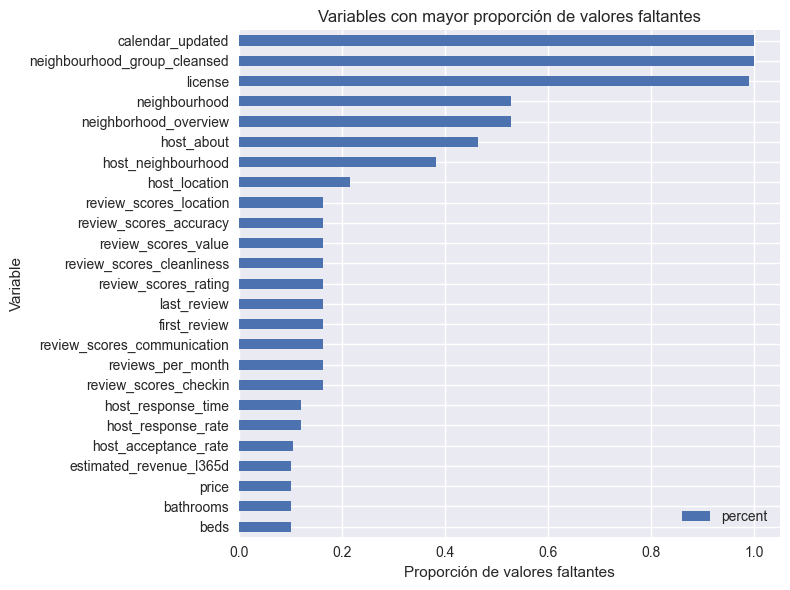

In [11]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing = missing_table[missing_table['percent'] > 0].head(25)
ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')
plt.tight_layout()
plt.show()


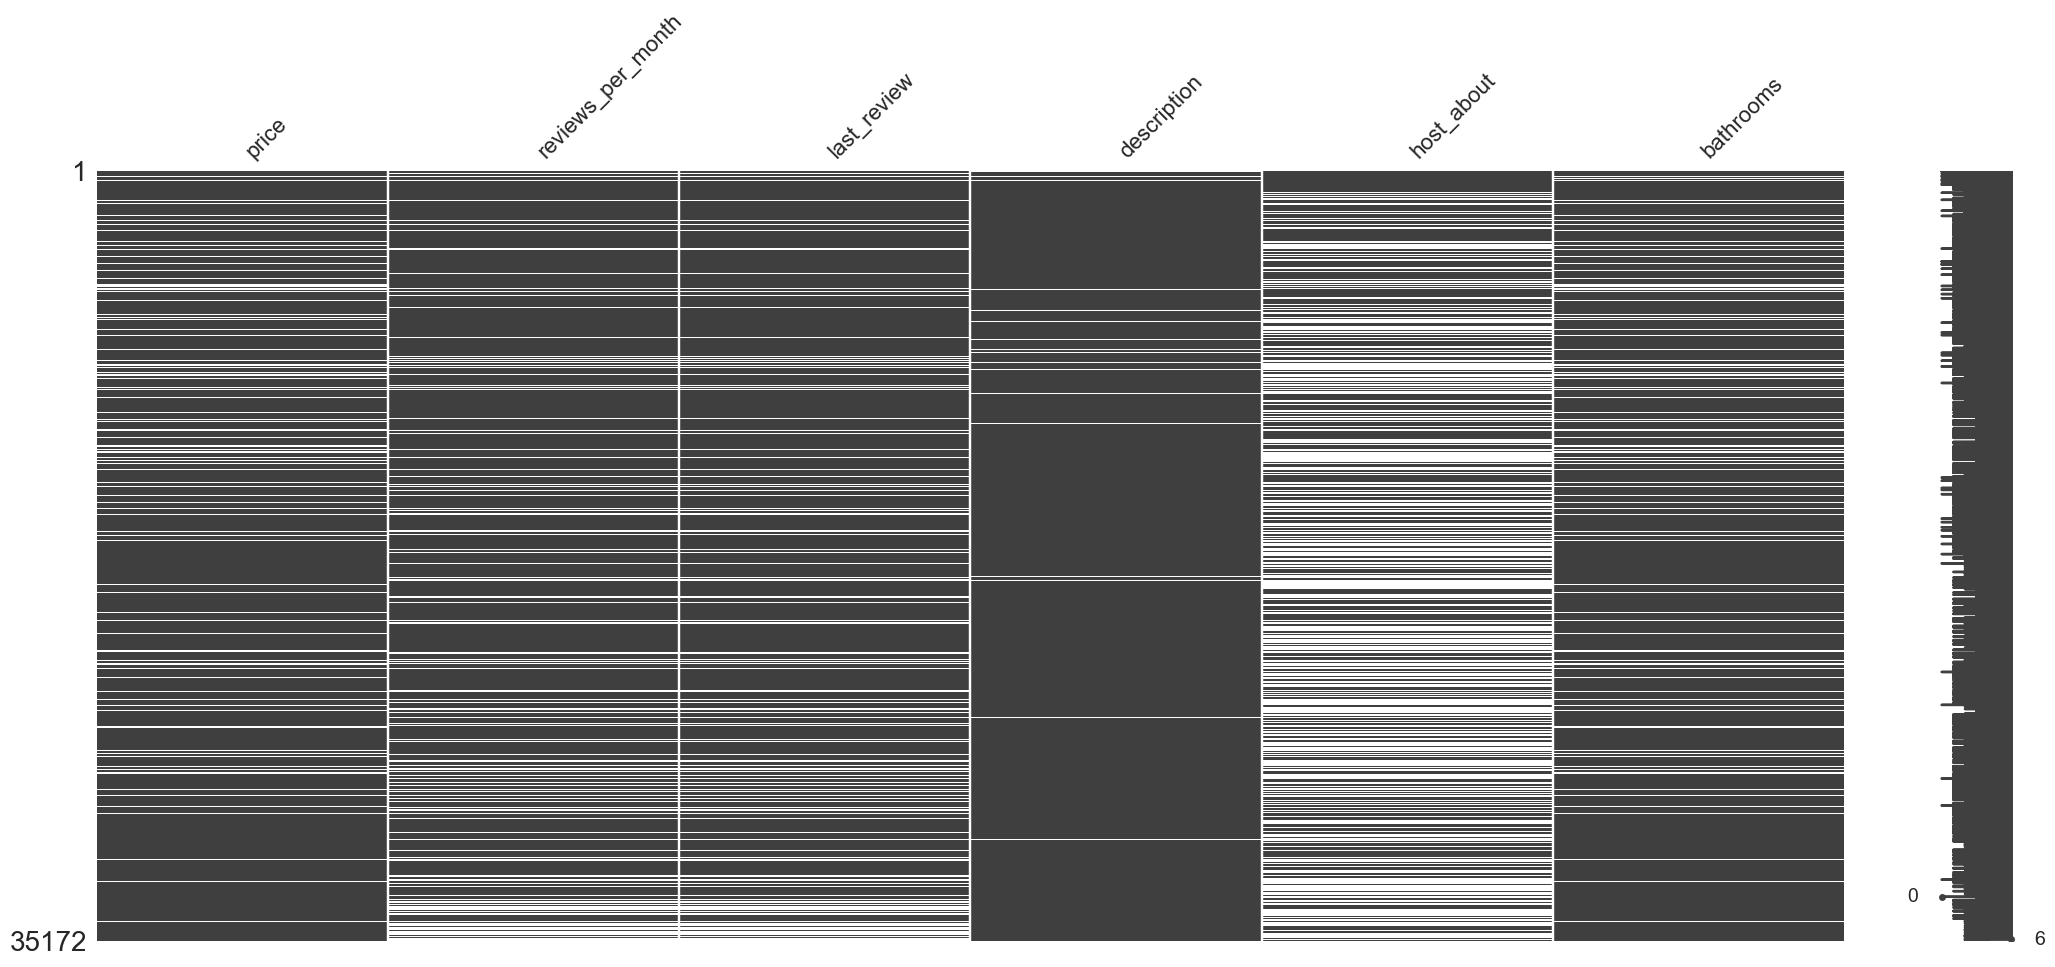

In [12]:
# Matriz de missingness para detectar patrones
try:
    import missingno as msno
    msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
    plt.show()
except ImportError:
    print('missingno no está disponible en el entorno actual.')


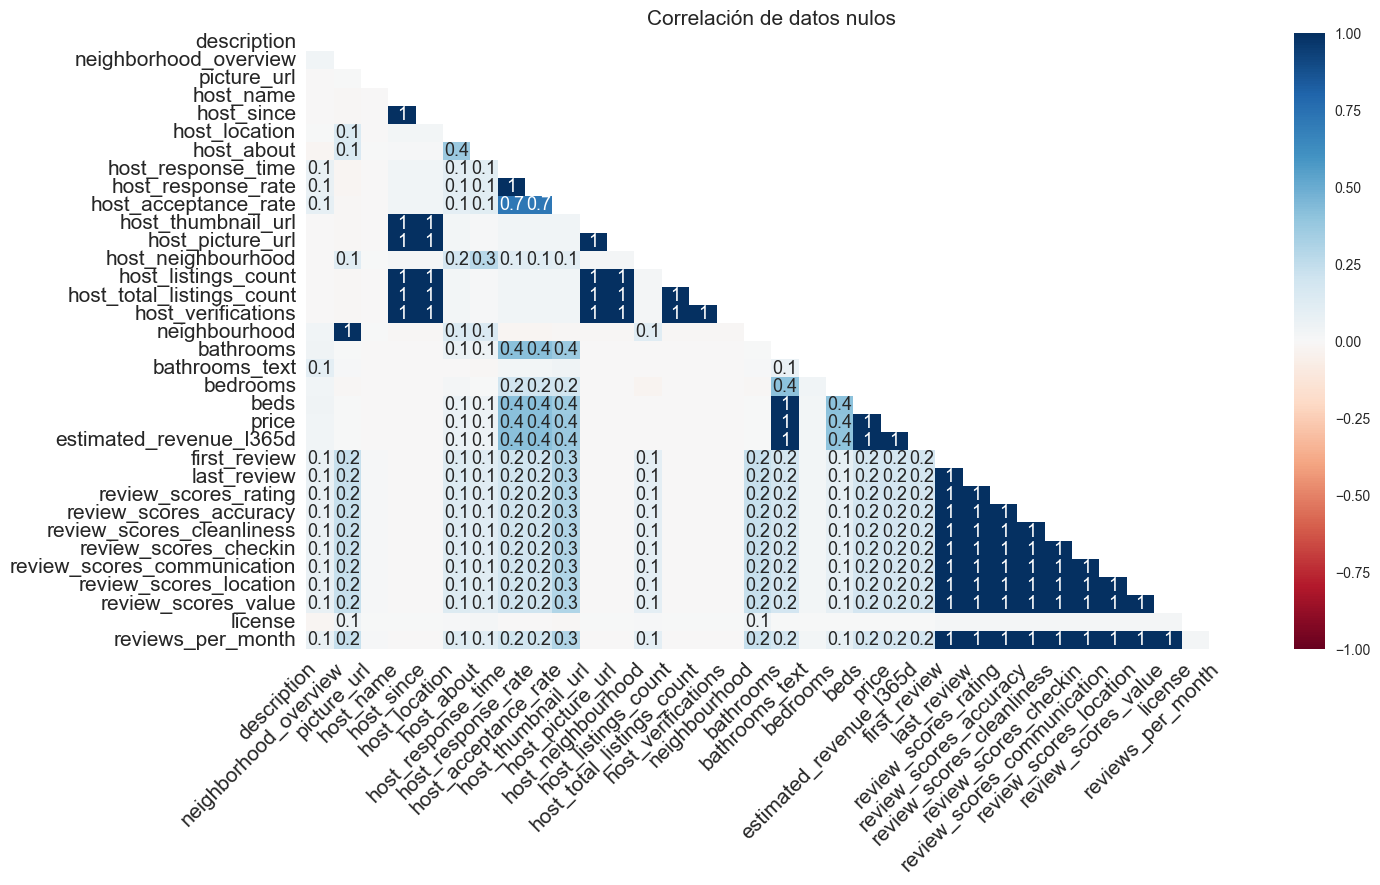

In [13]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

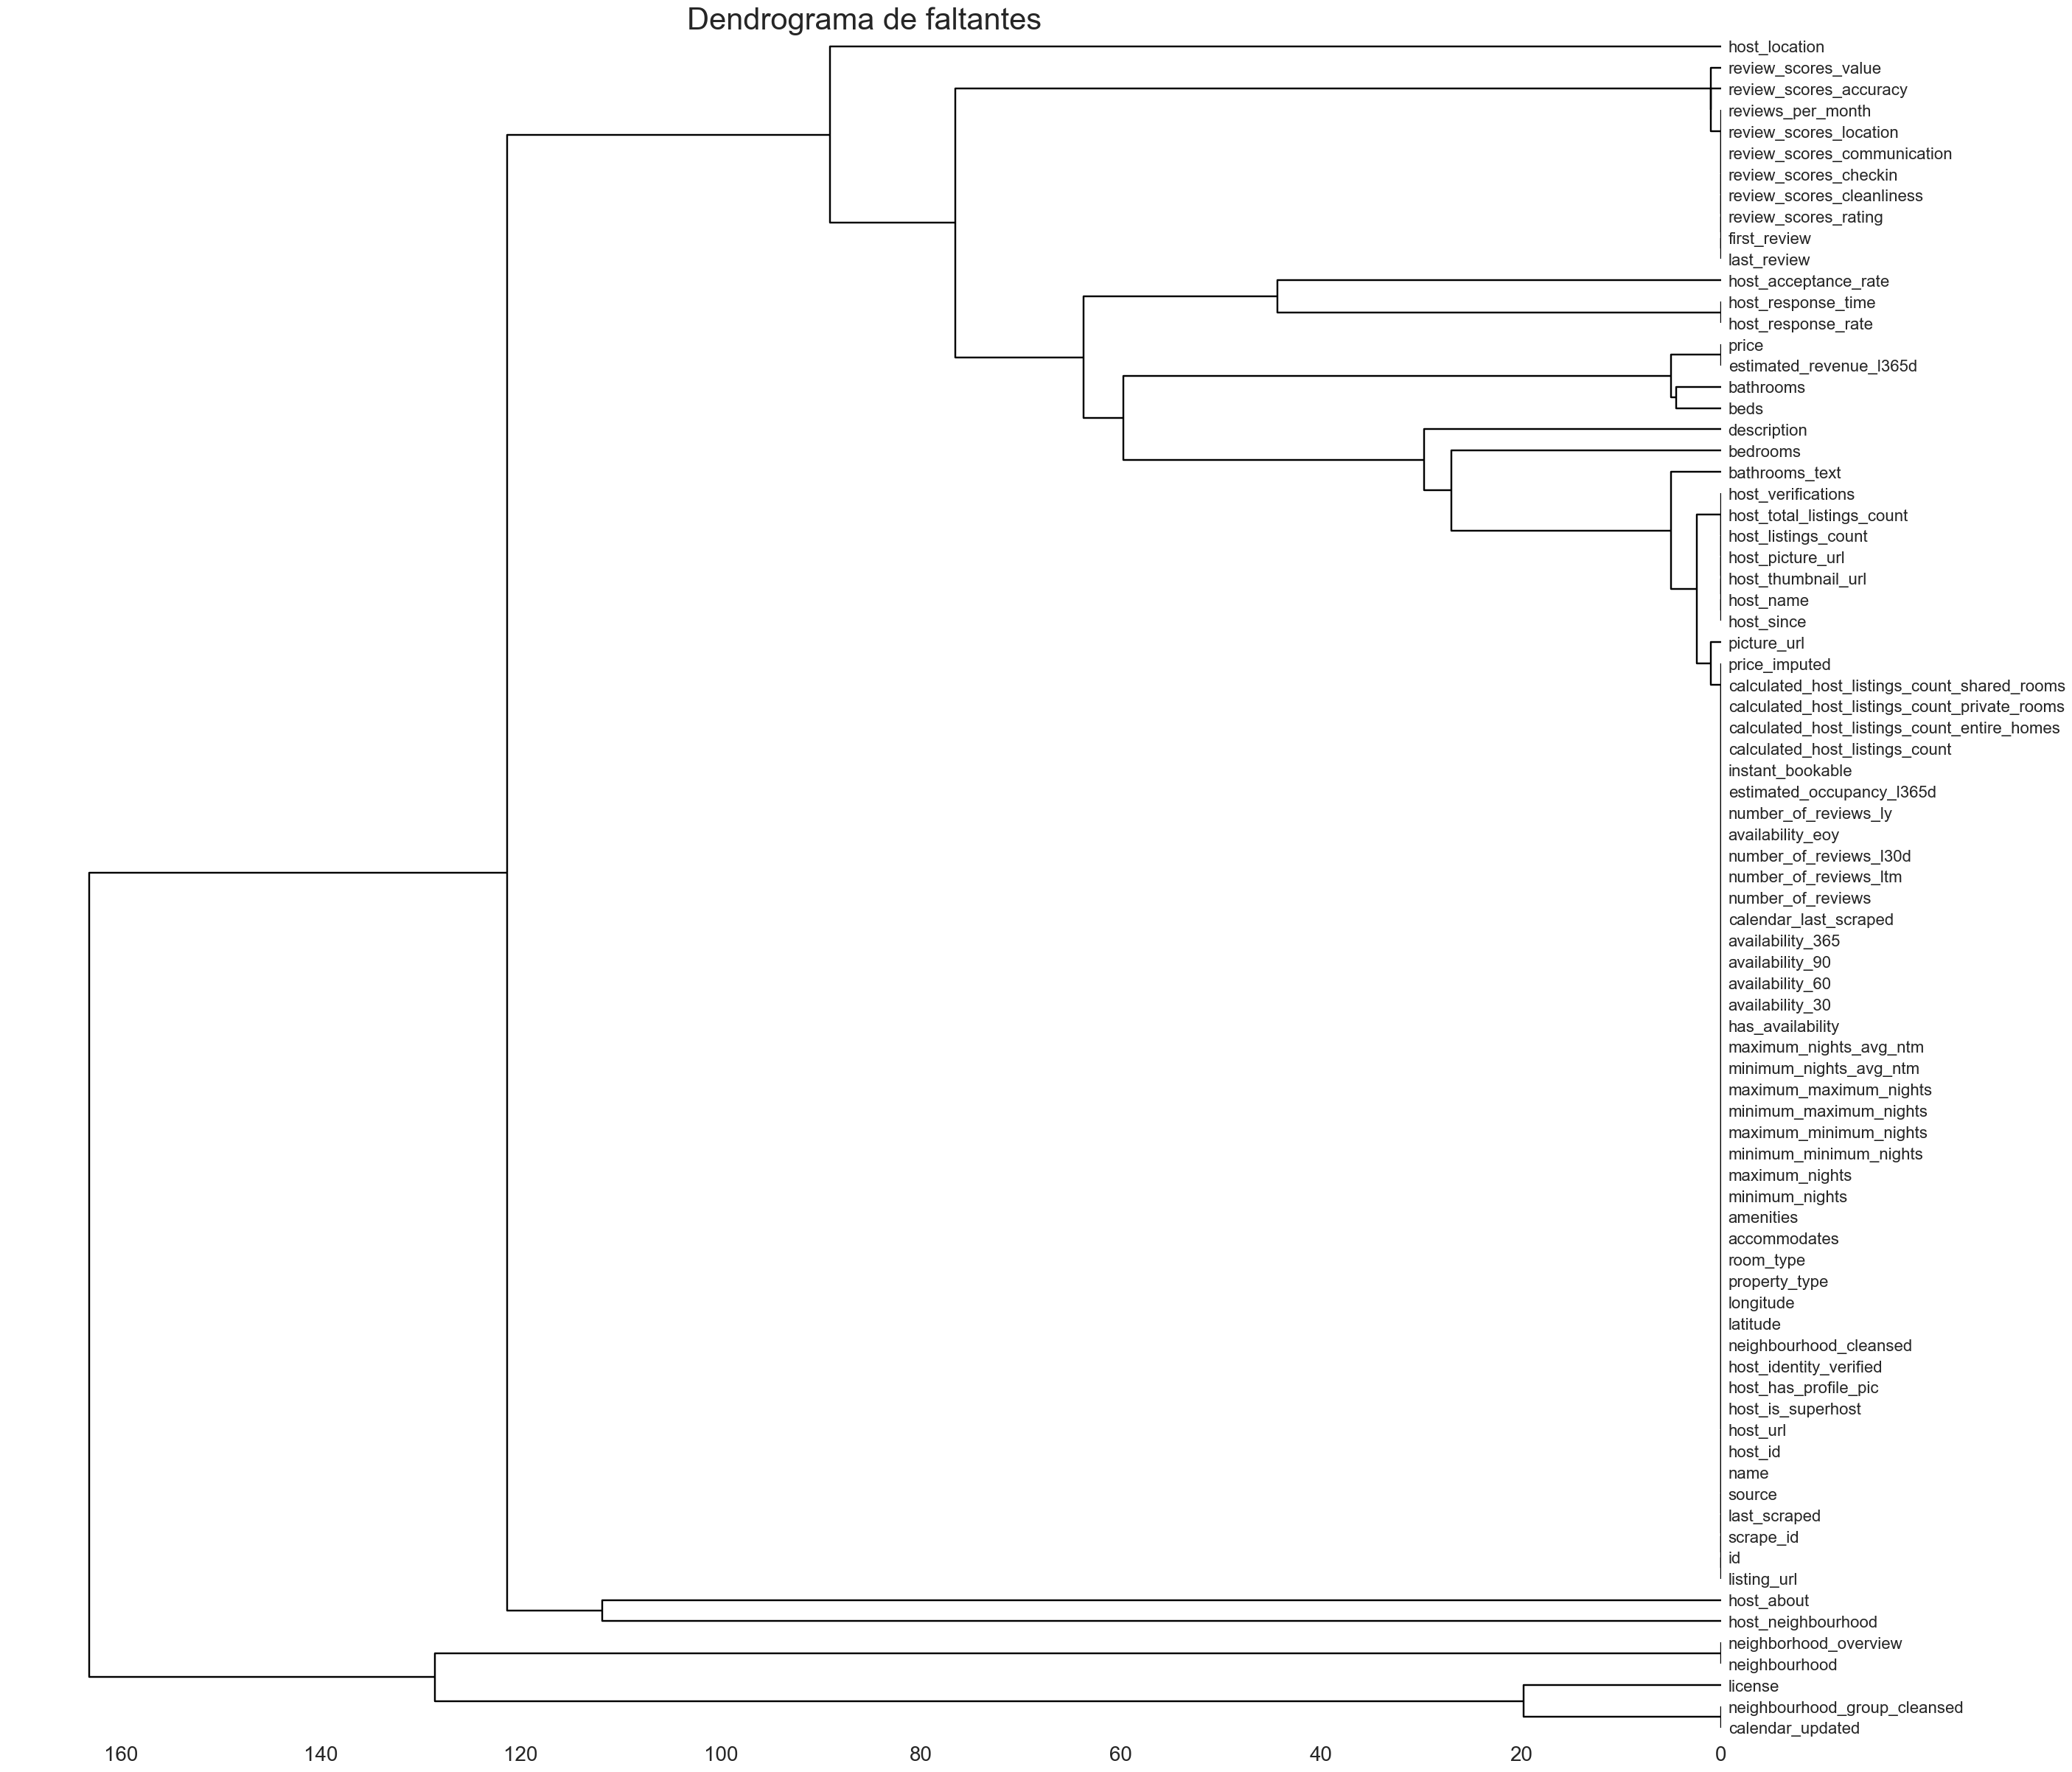

In [14]:
msno.dendrogram(df, figsize=(30,30))
plt.title('Dendrograma de faltantes', fontsize=30)
plt.show()

De aca podemos llegar a la conclusion de que

Las tres columnas con mas nulos son calendar_updated, neighbourhood_group_cleansed y license. Vemos que tienen relacion entre ellas, pero que con el resto de los datos no hay practicamente relacion.

In [15]:


# Helpers para detectar nulos SIN modificar el DataFrame 
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def missing_mask(series: pd.Series) -> pd.Series:
    """True cuando el valor debe considerarse nulo (NaN real o string vacío)."""
    base_mask = series.isna()
    string_mask = series.astype(str).str.strip().isin(NULL_TOKENS)
    return base_mask | string_mask

# Construcción de features de referencia 
def build_numeric_features(df: pd.DataFrame, min_valid_frac: float = 0.50) -> dict:
    numeric_features = {}
    for col in df.columns:
        series = df[col]
        cleaned = (
            series.astype(str)
                  .str.replace(r"[^\d\.\-]", "", regex=True)
                  .replace("", pd.NA)
        )
        numeric = pd.to_numeric(cleaned, errors="coerce")
        if numeric.notna().mean() >= min_valid_frac:
            numeric_features[col] = numeric
    return numeric_features

def build_categorical_features(df: pd.DataFrame, max_cardinality: int = 30) -> dict:
    categorical_features = {}
    for col in df.columns:
        series = df[col]
        if series.dtype == "O" or series.dtype == "bool":
            if 1 <= series.dropna().nunique() <= max_cardinality:
                categorical_features[col] = series.fillna("Missing")
    return categorical_features

numeric_features = build_numeric_features(df)
categorical_features = build_categorical_features(df)

# Medidas de asociación entre patrón de nulos y otras columnas 
def numeric_effect(nan_mask: pd.Series, series: pd.Series):
    available = series.notna()
    if available.sum() == 0:
        return None
    miss = nan_mask & available
    present = (~nan_mask) & available
    if miss.sum() == 0 or present.sum() == 0:
        return None
    diff = series[miss].mean() - series[present].mean()
    std = series[available].std()
    if pd.isna(std) or std == 0:
        return None
    return abs(diff) / std  # diferencia estandarizada

def categorical_effect(nan_mask: pd.Series, series: pd.Series):
    miss = nan_mask
    present = ~nan_mask
    if miss.sum() == 0 or present.sum() == 0:
        return None
    freq_miss = series[miss].value_counts(normalize=True)
    freq_present = series[present].value_counts(normalize=True)
    combined = pd.concat([freq_miss, freq_present], axis=1, keys=["missing", "present"]).fillna(0)
    combined["diff"] = (combined["missing"] - combined["present"]).abs()
    return combined["diff"].max()

# Clasificación MCAR / MAR / MNAR / Estructural 
missing_counts = {col: missing_mask(df[col]).sum() for col in df.columns}
missing_pct = {col: round(count / len(df) * 100, 2) for col, count in missing_counts.items()}
missing_summary = (
    pd.DataFrame({"missing": missing_counts, "missing_pct": missing_pct})
      .query("missing > 0")
      .sort_values("missing_pct", ascending=False)
)

results = []
row_count = len(df)

for col in missing_summary.index:
    mask = missing_mask(df[col])

    if missing_summary.loc[col, "missing"] == row_count:
        results.append({
            "column": col,
            "missing": missing_summary.loc[col, "missing"],
            "missing_pct": missing_summary.loc[col, "missing_pct"],
            "category": "Estructural",
            "driver": None,
            "effect_size": None,
            "notes": "100% ausente en el scrape; indicio de campo no disponible en la fuente."
        })
        continue

    best_effect = 0
    best_driver = None
    best_type = None

    for driver, series in numeric_features.items():
        if driver == col:
            continue
        effect = numeric_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = driver
            best_type = "numérico"

    for driver, series in categorical_features.items():
        if driver == col:
            continue
        effect = categorical_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = f"{driver} (categoría)"
            best_type = "categórico"

    if best_effect < 0.05 or best_driver is None:
        category = "MCAR"
        notes = "No se detectan asociaciones significativas con variables observadas."
    else:
        if missing_summary.get("missing_pct", pd.Series()).get(best_driver.replace(" (categoría)", ""), 0) < 50:
            category = "MAR"
            notes = f"Patrón de ausencias relacionado con {best_driver}; efecto {best_effect:.2f} ({best_type})."
        else:
            category = "MNAR"
            notes = (
                f"Hay asociación (efecto {best_effect:.2f}) pero el driver también está muy incompleto "
                "o depende de factores no observados; se clasifica como MNAR."
            )

    results.append({
        "column": col,
        "missing": missing_summary.loc[col, "missing"],
        "missing_pct": missing_summary.loc[col, "missing_pct"],
        "category": category,
        "driver": best_driver,
        "effect_size": round(best_effect, 3) if best_effect is not None else None,
        "notes": notes
    })

missing_classification = pd.DataFrame(results).sort_values(["category", "missing_pct"], ascending=False)
missing_classification


,column,missing,missing_pct,category,driver,effect_size,notes
2,license,34782,98.8900,MAR,id,1.0010,Patrón de ausencias relacionado con id; efecto...
3,neighborhood_overview,18584,52.8400,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
4,neighbourhood,18584,52.8400,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
5,host_about,16303,46.3500,MAR,host_id,0.6840,Patrón de ausencias relacionado con host_id; e...
6,host_neighbourhood,13451,38.2400,MAR,host_id,0.6480,Patrón de ausencias relacionado con host_id; e...
7,host_location,7553,21.4700,MAR,host_id,1.0280,Patrón de ausencias relacionado con host_id; e...
8,reviews_per_month,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
9,review_scores_accuracy,5761,16.3800,MAR,review_scores_cleanliness,9.7900,Patrón de ausencias relacionado con review_sco...
10,first_review,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
11,last_review,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...


**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


## 2.1 Tratamiento de nulos

### 2.1.1 Las columnas

- neighbourhood_group_cleansed (100% nulos)
- calendar_updated (100% nulos)
- license (99% nulos)

las eliminamos

In [16]:
df = df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated','license'] )

### 2.1.2 La columna booleanas

- Si has_availability es nula, la completamos con yes si la suma de availability_30, availability_60, availability_90 y availability_365 es distinta de cero y con no si la suma es igual a cero
- Si host_is_superhost no esta definida, significa que puede ser un listing nuevo que aun no fue evaluado por airbnb para ver si califica o no, con lo cual es importante diferenciar de un no. Para eso a los nulos le ponemos no, pero creamos una nueva columna llamada was_evaluated_for_superhost para diferenciarlos de los ya evaluados

In [17]:
cols_sumar = ['availability_30','availability_60', 'availability_90', 'availability_365']

df.loc[
    (df[cols_sumar].sum(axis=1) != 0) & (df['has_availability'].isna()),
    'has_availability'
] = 't'

df.loc[
    (df[cols_sumar].sum(axis=1) == 0) & (df['has_availability'].isna()),
    'has_availability'
] = 'f'

for col in ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        df[col] = df[col].replace({'t': 'yes', 'f': 'no'})

# is_superhost

df['was_evaluated_for_superhost'] = ~df['host_is_superhost'].isna()
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 'yes', 'f': 'no'}).fillna('no')

print(df['host_is_superhost'].unique())

print(df['was_evaluated_for_superhost'].unique())


['no']
[ True]


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

- La columna neighbourhood completamos con la del valor codificado neighbourhood_cleansed que es el valor ya codificado de la ubicacion
- La columna neighbourhood_overview le asignamos la clasificacion "not defined"
- La columna host_location y host_about le asignamos la clasificacion "not defined"


In [18]:
df['neighbourhood'] = df['neighbourhood'].fillna(df['neighbourhood_cleansed'])

cols = ['neighborhood_overview', 'host_location', 'host_about','host_neighbourhood']

for col in cols:
    df[col] = (
        df[col]
            .astype('string')                         # convierte a string (dtype nativo)
            .replace(r'^\s*$', pd.NA, regex=True)     # "" o espacios → NA
            .fillna('not-defined')                    # completa NA
    )

missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)


,missing,percent
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800
review_scores_rating,5760,16.3800
first_review,5760,16.3800
review_scores_cleanliness,5760,16.3800
review_scores_communication,5760,16.3800
review_scores_location,5760,16.3800
last_review,5760,16.3800
review_scores_checkin,5760,16.3800
reviews_per_month,5760,16.3800


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

Podemos observar que el porcentaje de nulos de las columnas asociadas a las reviews es el mismo (16.7%) y coincide con que no hay ni fecha de first_review ni fecha de last_review, esto nos muestra que posiblemente esos listings aun no tengan ninguna review asociada, con lo cual tiene sentido que sean nulos las reviews por aspecto del alojamiento. Lo que vamos a hacer es asignarle un cero pero ademas vamos a crear una nueva columna que indique si el listing tiene reviews o no.

- review_scores_accuracy	    4725	16.7600
- review_scores_value	        4725	16.7600
- reviews_per_month	            4724	16.7600
- first_review	                4724	16.7600
- last_review	                4724	16.7600
- review_scores_rating	        4724	16.7600
- review_scores_location	    4724	16.7600
- review_scores_communication	4724	16.7600
- review_scores_checkin	        4724	16.7600
- review_scores_cleanliness	    4724	16.7600


In [19]:
cols_scores = [
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]

# 1) Definir fecha de referencia para calcular la  cantidad de dias desde la ultima review en base al maximo

reference_date = max(df['first_review'].max(), df['last_review'].max())

print("Fecha de referencia:", reference_date)

for c in cols_scores:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 2) Flag "tiene reviews"

has_num_reviews = df['number_of_reviews'] > 0 if 'number_of_reviews' in df.columns else False
has_first = df['first_review'].notna() if 'first_review' in df.columns else False
has_last  = df['last_review'].notna()  if 'last_review'  in df.columns else False
has_rpm   = (df['reviews_per_month'].fillna(0) > 0) if 'reviews_per_month' in df.columns else False

df['has_reviews'] = (has_num_reviews | has_first | has_last | has_rpm).astype(bool)

# 3) Poner 0 en scores solo cuando no hay reviews
df.loc[~df['has_reviews'], [c for c in cols_scores if c in df.columns]] = 0

# 3) Crear días desde primera review
df['days_since_first_review'] = np.where(
    df['has_reviews'] == 1,
    (reference_date - df['first_review']).dt.days,
    -1  # -1 indica que no tiene reviews
)

# 4) Crear días desde última review
df['days_since_last_review'] = np.where(
    df['has_reviews'] == 1,
    (reference_date - df['last_review']).dt.days,
    -1
)

if 'reviews_per_month' in df.columns:
    df.loc[~df['has_reviews'] & df['reviews_per_month'].isna(), 'reviews_per_month'] = 0.0

df.drop(columns=['first_review', 'last_review'], inplace=True)

missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)

Fecha de referencia: 2025-01-30 00:00:00


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
beds,3568,10.1400
description,873,2.4800
bedrooms,727,2.0700
bathrooms_text,24,0.0700


## 3. Distribuciones y visualizaciones clave


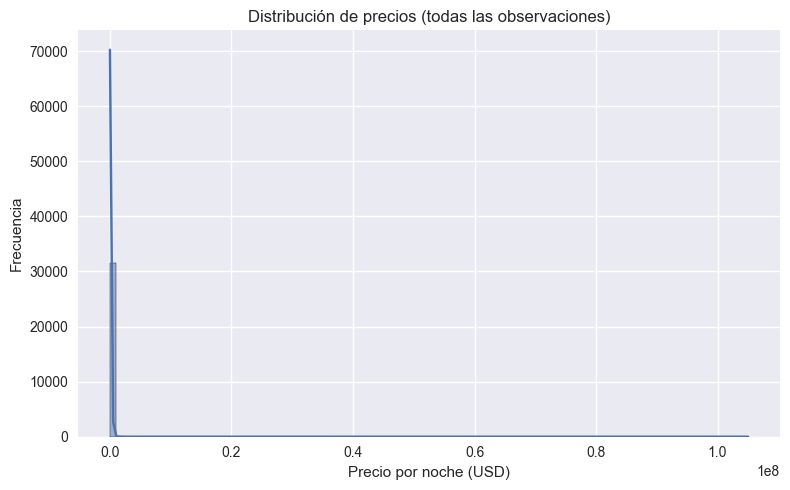

In [20]:
sns.histplot(df['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


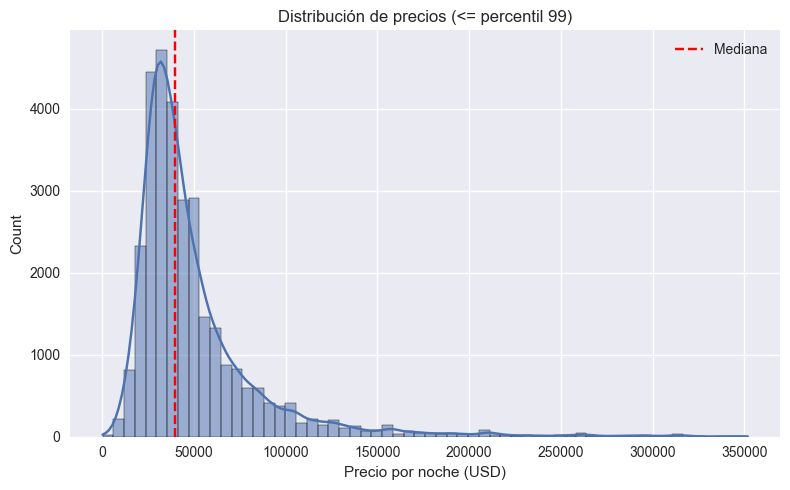

In [21]:
# Distribución recortando el 1% superior para atenuar outliers
price_cap = df['price'].quantile(0.99)
sns.histplot(df.loc[df['price'] <= price_cap, 'price'], bins=60, kde=True)
plt.axvline(df['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (<= percentil 99)')
plt.xlabel('Precio por noche (USD)')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Skewness de precios para evaluar la asimetría
price_series = df['price'].dropna()
price_skew = price_series.skew()
positive_prices = price_series[price_series > 0]
price_log_skew = np.log1p(positive_prices).skew() if not positive_prices.empty else np.nan
print(f'Skewness (precio bruto): {price_skew:.3f}')
print(f'Skewness (log1p del precio): {price_log_skew:.3f}')


Skewness (precio bruto): 42.181
Skewness (log1p del precio): 2.009


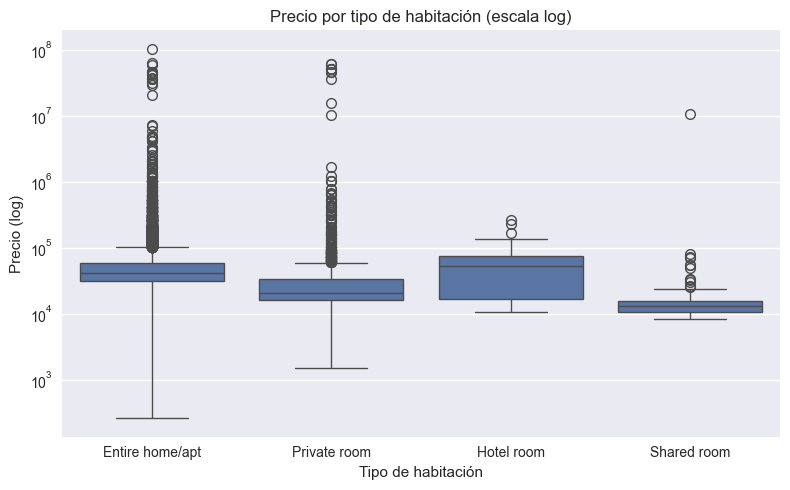

In [23]:
sns.boxplot(data=df, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


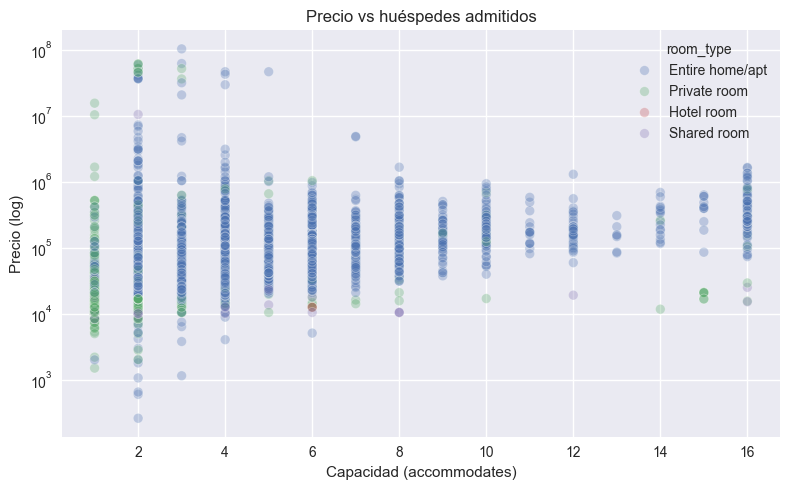

In [24]:
# Precio vs capacidad
sns.scatterplot(data=df, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


### Distribuciones de disponibilidad y ocupación


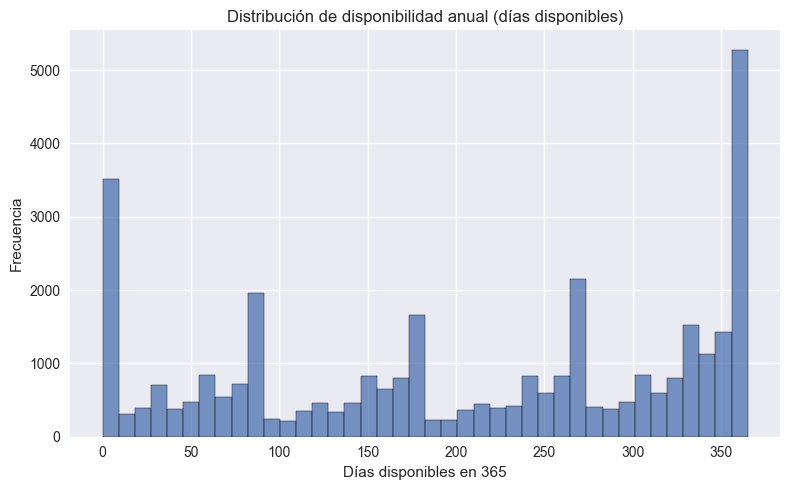

In [25]:
sns.histplot(df['availability_365'], bins=40, kde=False)
plt.title('Distribución de disponibilidad anual (días disponibles)')
plt.xlabel('Días disponibles en 365')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


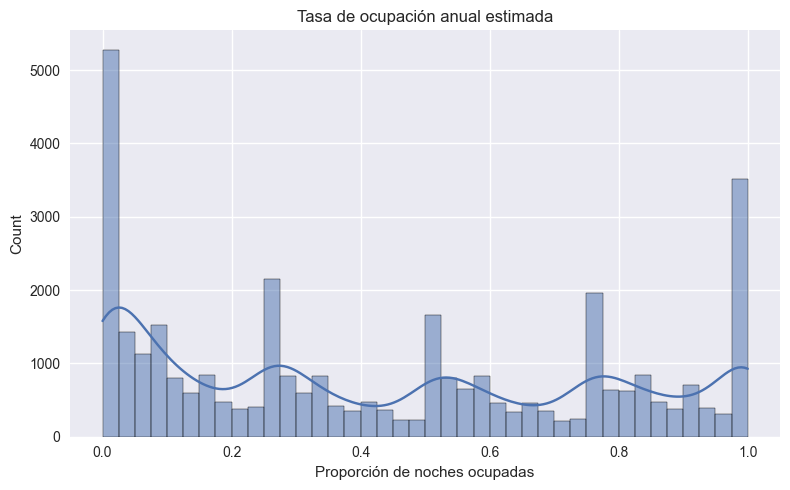

In [26]:
sns.histplot(1 - (df['availability_365'] / 365), bins=40, kde=True)
plt.title('Tasa de ocupación anual estimada')
plt.xlabel('Proporción de noches ocupadas')
plt.tight_layout()
plt.show()


### Correlación orientada a disponibilidad (categóricas codificadas)
Para estudiar los drivers de disponibilidad aplicamos one-hot encoding sobre las variables categóricas y analizamos la correlación con las tasas de ocupación.


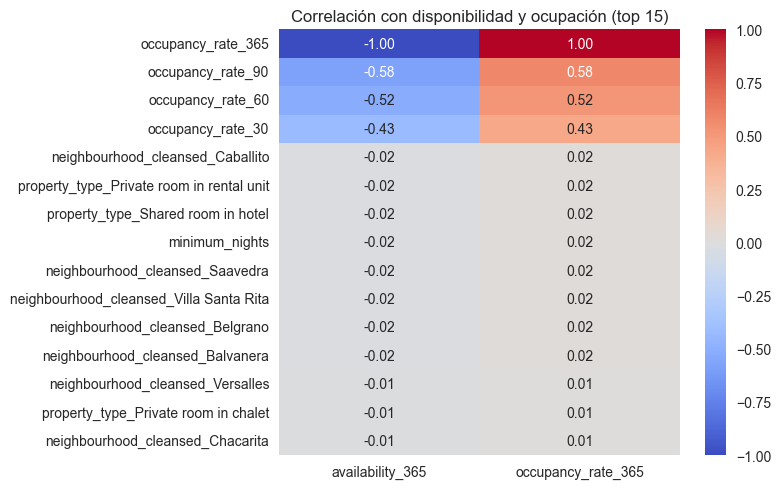

,availability_365,occupancy_rate_365
occupancy_rate_365,-1.0000,1.0000
occupancy_rate_90,-0.5822,0.5822
occupancy_rate_60,-0.5201,0.5201
occupancy_rate_30,-0.4259,0.4259
neighbourhood_cleansed_Caballito,-0.0217,0.0217
property_type_Private room in rental unit,-0.0193,0.0193
property_type_Shared room in hotel,-0.0187,0.0187
minimum_nights,-0.0186,0.0186
neighbourhood_cleansed_Saavedra,-0.0177,0.0177
neighbourhood_cleansed_Villa Santa Rita,-0.0174,0.0174


In [27]:
# Codificación de categóricas para matriz de correlación orientada a disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
base_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'reviews_per_month', 'price']

corr_base = df[base_columns + availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    if rate_col not in df.columns:
        df[rate_col] = 1 - (df[f'availability_{horizon}'] / horizon)
    corr_base[rate_col] = df[rate_col]

binary_map = {'yes': 1, 'no': 0}
for col in ['host_is_superhost', 'instant_bookable']:
    corr_base[f'{col}_flag'] = df[col].map(binary_map)

categorical_for_corr = ['room_type', 'property_type', 'neighbourhood_cleansed']
corr_encoded = pd.get_dummies(
    pd.concat([corr_base, df[categorical_for_corr]], axis=1),
    columns=categorical_for_corr,
    drop_first=True
)

corr_matrix = corr_encoded.corr(numeric_only=True)
target_corr = corr_matrix[['availability_365', 'occupancy_rate_365']].sort_values(
    by='occupancy_rate_365', ascending=False
)

top_features = target_corr.head(15).index
sns.heatmap(
    corr_matrix.loc[top_features, ['availability_365', 'occupancy_rate_365']],
    annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlación con disponibilidad y ocupación (top 15)')
plt.tight_layout()
plt.show()

target_corr.head(15)


## 4. Disponibilidad y objetivo de ocupación


In [28]:
# Cálculo de tasas de ocupación a partir de la disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
occupancy_df = df[availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    df[rate_col] = 1 - (df[f'availability_{horizon}'] / horizon)
    occupancy_df[rate_col] = df[rate_col]

occupancy_summary = occupancy_df[[f'occupancy_rate_{h}' for h in [30, 60, 90, 365]]].describe().T
print(occupancy_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Target multiclase basado en la tasa anual
bins = [0.0, 0.4, 0.7, 1.01]
labels = ['low', 'mid', 'high']
df['occupancy_level'] = pd.cut(
    df['occupancy_rate_365'].clip(lower=0, upper=1),
    bins=bins, labels=labels, right=False, include_lowest=True
)

level_counts = df['occupancy_level'].value_counts(dropna=False).sort_index()
print('Distribución de occupancy_level:')
print(level_counts)
print('Proporciones:')
print((level_counts / len(df)).round(3))


                     mean    std    min    25%    50%    75%    max
occupancy_rate_30  0.5098 0.4009 0.0000 0.0667 0.5000 1.0000 1.0000
occupancy_rate_60  0.4457 0.3796 0.0000 0.0500 0.3833 0.8333 1.0000
occupancy_rate_90  0.3935 0.3660 0.0000 0.0444 0.3000 0.6889 1.0000
occupancy_rate_365 0.4339 0.3457 0.0000 0.0877 0.3671 0.7589 1.0000
Distribución de occupancy_level:
occupancy_level
low     18047
mid      6834
high    10291
Name: count, dtype: int64
Proporciones:
occupancy_level
low    0.5130
mid    0.1940
high   0.2930
Name: count, dtype: float64


**Decisión:** Se utilizará la etiqueta multiclase `occupancy_level` para representar la ocupación esperada (low/mid/high). El objetivo del modelado es predecir este nivel sin emplear variables de disponibilidad futuras.


## 5. Planteo del problema supervisado
Planteamos un problema de **clasificación multiclase** donde la variable target es `occupancy_level`, construida a partir de la tasa de ocupación anual estimada. Los niveles son:
- `high`: ocupación >= 70%
- `mid`: ocupación entre 40% y 70%
- `low`: ocupación < 40%

El objetivo es anticipar la categoría de ocupación utilizando únicamente atributos conocidos al momento de publicar un listing (sin recurrir a disponibilidades futuras). Se evaluará con métricas como F1 macro, balanced accuracy y matrices de confusión para garantizar buen desempeño en las tres clases.

Las features consideradas combinan atributos de ubicación (`latitude`, `longitude`, `neighbourhood_cleansed`), configuración (`room_type`, `property_type`, `accommodates`, `bedrooms`), reputación (`number_of_reviews`, `reviews_per_month`, `host_is_superhost`) y métricas derivadas de la actividad del host (`host_tenure_days`, `reviews_per_year`, `days_since_last_review`).


**Definición del target:** `occupancy_level` surge de discretizar la tasa de ocupación anual en tres bandas (`low`, `mid`, `high`) con umbrales (0.0, 0.4, 0.7, 1.0]. Esto permite capturar distintos perfiles de demanda y evita depender de la disponibilidad futura como feature. Registros sin información suficiente quedan con valor nulo y se descartan durante el split de entrenamiento.


## 6. Ingeniería de features y preprocesamiento


### 6.1 Codificación de amenities

Normalizamos la columna JSON de `amenities`, homogenizamos etiquetas y generamos indicadores binarios para las 20 amenidades más frecuentes; estas columnas (`amenity_*`) amplían el set de features con información interpretable.


In [29]:
# Normalizamos la columna de amenities y generamos indicadores binarios
def normalize_amenities(value):
    if pd.isna(value):
        return []
    text = str(value).strip()
    if not text:
        return []
    candidate = text.replace('{', '[').replace('}', ']')
    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        try:
            parsed = ast.literal_eval(candidate)
        except (ValueError, SyntaxError):
            parsed = [item.strip() for item in candidate.strip('[]').split(',')]
    normalized = []
    for item in parsed:
        token = str(item).strip().strip('"').strip("'")
        if token:
            normalized.append(token.lower())
    return sorted(set(normalized))

amenity_lists = df['amenities'].apply(normalize_amenities)
amenity_counts = amenity_lists.explode().value_counts()
top_k = 20
top_amenities = amenity_counts.head(top_k)

def amenity_to_col(amenity):
    slug = re.sub(r'[^a-z0-9]+', '_', amenity).strip('_')
    return f'amenity_{slug}' if slug else 'amenity_other'

amenities_feature_cols = []
for amenity in top_amenities.index:
    base_name = amenity_to_col(amenity)
    name = base_name
    suffix = 1
    while name in amenities_feature_cols:
        suffix += 1
        name = f"{base_name}_{suffix}"
    amenities_feature_cols.append(name)
    df[name] = amenity_lists.apply(lambda items, target=amenity: int(target in items))

top_amenities.to_frame(name='count').assign(percent=lambda data: data['count'] / len(df))



,count,percent
amenities,,
kitchen,33356,0.9484
wifi,31437,0.8938
hot water,27872,0.7924
dishes and silverware,27376,0.7783
cooking basics,26425,0.7513
hangers,25869,0.7355
essentials,24959,0.7096
bed linens,24876,0.7073
refrigerator,23538,0.6692


In [30]:
# Feature engineering orientado a ocupación
# Imputar reseñas por mes faltantes con 0 (sugiere ausencia de reseñas)
df['reviews_per_month_filled'] = df['reviews_per_month'].fillna(0)

# Antigüedad del host y tiempo desde la última reseña
reference_date = df['last_scraped'].max()
df['host_tenure_days'] = (reference_date - df['host_since']).dt.days

df['days_since_last_review'] = (reference_date - df['last_review']).dt.days

# Densidad de reseñas: reviews acumulados sobre tenure (evitar división por cero)
df['reviews_per_year'] = df['number_of_reviews'] / (df['host_tenure_days'] / 365)
df.loc[df['host_tenure_days'] <= 0, 'reviews_per_year'] = np.nan

# Construimos dataset sin columnas de disponibilidad para evitar fuga de información
amenities_feature_cols = globals().get('amenities_feature_cols', [])
base_feature_cols = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'price_imputed',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type',
    'neighbourhood_cleansed', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

feature_cols = base_feature_cols + amenities_feature_cols

model_df = df[feature_cols + ['occupancy_level']].copy()
model_df.head()



KeyError: 'last_review'

### 6.2 Correlación lineal de features

Convertimos el dataset de modelado a una versión numérica (incluyendo el target codificado) para inspeccionar la matriz de correlación y priorizar las variables con mayor vínculo lineal con `occupancy_level`.


No hay features con |correlación| >= 0.4


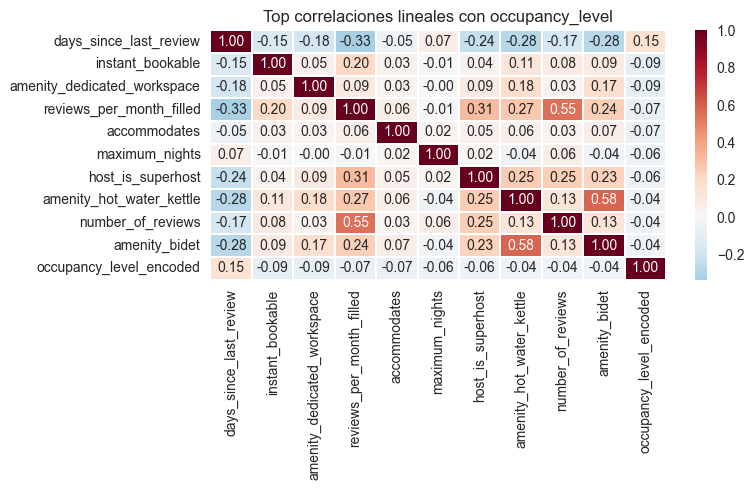

,correlation_with_target
days_since_last_review,0.1540
instant_bookable,-0.0940
amenity_dedicated_workspace,-0.0850
reviews_per_month_filled,-0.0710
accommodates,-0.0650
maximum_nights,-0.0610
host_is_superhost,-0.0580
amenity_hot_water_kettle,-0.0450
number_of_reviews,-0.0450
amenity_bidet,-0.0410


In [ ]:
# Matriz de correlación (features numéricos + target codificado)
correlation_df = model_df.dropna(subset=['occupancy_level']).copy()
target_mapping = {'low': 0, 'mid': 1, 'high': 2}
target_encoded = correlation_df['occupancy_level'].map(target_mapping)

feature_matrix = correlation_df.drop(columns=['occupancy_level'])

binary_map = {'yes': 1, 'no': 0}
binary_cols = [col for col in ['host_is_superhost', 'instant_bookable'] if col in feature_matrix.columns]
for col in binary_cols:
    feature_matrix[col] = feature_matrix[col].map(binary_map)

categorical_cols = feature_matrix.select_dtypes(include='object').columns
feature_matrix = pd.get_dummies(feature_matrix, columns=categorical_cols, drop_first=True)

corr_ready = feature_matrix.assign(occupancy_level_encoded=target_encoded)
corr_matrix = corr_ready.corr().round(3)

corr_with_target = corr_matrix['occupancy_level_encoded'].drop('occupancy_level_encoded').dropna().sort_values(key=lambda s: s.abs(), ascending=False)

top_n = min(20, len(corr_with_target))
threshold = 0.4
corr_filtered = corr_with_target[ corr_with_target.abs() >= threshold ]

if corr_filtered.empty:
    print(f'No hay features con |correlación| >= {threshold}')
    top_features = corr_with_target.head(10).index.tolist()
else:
    top_features = corr_filtered.index.tolist()

plot_cols = top_features + ['occupancy_level_encoded']

sns.heatmap(corr_matrix.loc[plot_cols, plot_cols], annot=True, fmt='.2f', cmap='RdBu_r', center=0, linewidths=0.2)
plt.title('Top correlaciones lineales con occupancy_level')
plt.tight_layout()
plt.show()

corr_with_target.head(top_n).to_frame(name='correlation_with_target')



In [ ]:
target_col = 'occupancy_level'
X = model_df.drop(columns=[target_col])
y = model_df[target_col]

print(f'Observaciones totales para modelado: {len(X)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 35172
Registros sin target: 0 (serán descartados antes del split)


In [ ]:
from sklearn.model_selection import train_test_split

valid_rows = y.notna()
X_valid = X.loc[valid_rows]
y_valid = y.loc[valid_rows]

X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (28137, 38), Test: (7035, 38)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

amenities_feature_cols = globals().get('amenities_feature_cols', [])

numeric_features = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

numeric_features += amenities_feature_cols

price_feature = ['price_imputed']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

price_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_features = [
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type', 'neighbourhood_cleansed'
]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('price', price_transformer, price_feature),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print(f'Matriz transformada - train: {X_train_prepared.shape}')
print(f'Matriz transformada - test: {X_test_prepared.shape}')



Matriz transformada - train: (28137, 151)
Matriz transformada - test: (7035, 151)


### Balance del target (low/mid/high)


In [ ]:
y_train.value_counts(normalize=True).sort_index()


occupancy_level
low    0.5131
mid    0.1942
high   0.2927
Name: proportion, dtype: float64

## 7. Selección y reducción de dimensionalidad


In [ ]:
# Importancia de features numéricas (ANOVA F-score)
from sklearn.feature_selection import f_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
f_scores, p_values = f_classif(numeric_matrix, y_train)

anova_scores = (pd.Series(f_scores, index=numeric_features)
                  .sort_values(ascending=False))
anova_scores


days_since_last_review               307.1369
beds                                 163.2510
reviews_per_month_filled             118.9288
amenity_dedicated_workspace          101.2460
amenity_bed_linens                    98.5533
amenity_dishes_and_silverware         93.7159
amenity_hot_water_kettle              87.1809
amenity_cooking_basics                79.3047
amenity_hot_water                     78.6775
amenity_hair_dryer                    71.7757
amenity_room_darkening_shades         69.0655
amenity_microwave                     67.3528
amenity_bidet                         63.7592
accommodates                          60.9520
number_of_reviews                     59.6431
amenity_hangers                       56.7605
maximum_nights                        54.8749
amenity_extra_pillows_and_blankets    54.8257
amenity_refrigerator                  46.6204
amenity_essentials                    41.2985
amenity_iron                          36.0932
amenity_elevator                  

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
selector = SelectKBest(score_func=mutual_info_classif, k=min(8, len(numeric_features)))
selector.fit(numeric_matrix, y_train)

selected_numeric = [numeric_features[i] for i in selector.get_support(indices=True)]
print('Mejores features numéricas según mutual information:', selected_numeric)


Mejores features numéricas según mutual information: ['maximum_nights', 'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year']


In [ ]:
from sklearn.decomposition import PCA

# Aplicamos PCA sobre features numéricas estandarizadas
numeric_imputed = preprocessor.named_transformers_['num'].fit_transform(X_train[numeric_features])
pca = PCA().fit(numeric_imputed)
explained_variance = pd.DataFrame({
    'componente': np.arange(1, len(pca.explained_variance_ratio_) + 1),
    'var_ratio': pca.explained_variance_ratio_,
    'var_acumulada': np.cumsum(pca.explained_variance_ratio_)
})
explained_variance.head(10)


,componente,var_ratio,var_acumulada
0,1,0.2467,0.2467
1,2,0.0707,0.3174
2,3,0.0666,0.3840
3,4,0.0565,0.4405
4,5,0.0483,0.4889
5,6,0.0439,0.5328
6,7,0.0332,0.5659
7,8,0.0312,0.5971
8,9,0.0307,0.6278
9,10,0.0301,0.6579


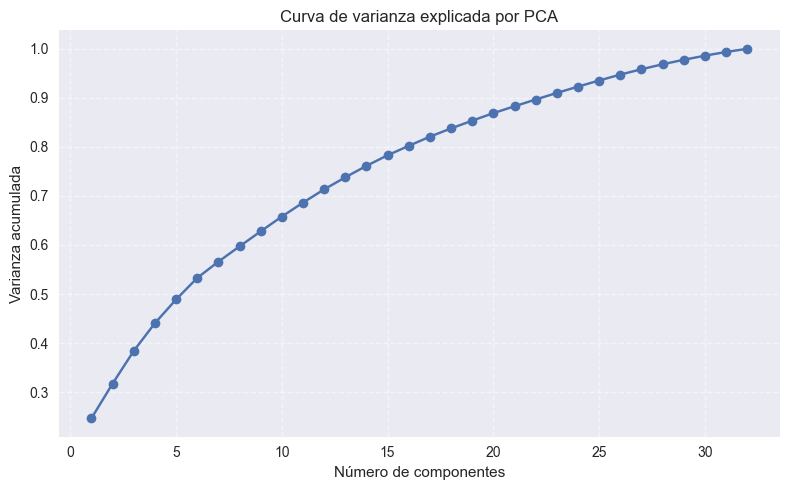

In [ ]:
plt.plot(explained_variance['componente'], explained_variance['var_acumulada'], marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza explicada por PCA')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interpretación:** Con ~6 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Próximos pasos sugeridos
- Entrenar clasificadores multiclase (`LogisticRegression`, `RandomForestClassifier`, `XGBoost`) usando el pipeline de `preprocessor`.
- Medir F1 macro, balanced accuracy y analizar la matriz de confusión para los niveles `low/mid/high`.
- Ajustar umbrales o reglas de decisión según la estrategia comercial (p. ej. priorizar recall de `high`).
- Incorporar nuevas variables disponibles al crear el anuncio (amenities, políticas, texto) para mejorar el poder predictivo sin depender de disponibilidad futura.


- Entrenar un modelo base (p. ej. `RandomForestRegressor`, `GradientBoostingRegressor`) usando el pipeline de `preprocessor`.
- Validar con una métrica robusta (MAE) y comparar contra un baseline como la mediana.
- Explorar ingeniería específica del vecindario (densidad de listings, precio medio por zona) y disponibilidad.
- Evaluar estrategias de tuning (GridSearch/Optuna) y monitoreo de drift con `wandb`.
